In [53]:
import trading_strategy
import torch
import utils
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme()

In [54]:
def synthetic_mean_reverting(batch_size: int, T: int, n:int, X_0: float, sigma_x: float, kappa: float):
    price_paths = torch.zeros(batch_size, n)
    
    price_paths[:,0] = X_0
    delta_t = T/n

    for i in range(1,n):
        price_paths[:,i] = price_paths[:,i-1] + kappa*(X_0-price_paths[:,i-1])*delta_t + sigma_x*price_paths[:,i-1]*torch.randn(batch_size)*np.sqrt(delta_t)

    return price_paths

def synthetic_drift(drift: float, batch_size: int, T: int, n:int, X_0: float, sigma_x: float):
    price_paths = torch.zeros(batch_size, n)
    
    price_paths[:,0] = X_0
    delta_t = T/n
    drift_term = drift*delta_t

    for i in range(1,n):
        price_paths[:,i] = price_paths[:,i-1] + drift_term + sigma_x*price_paths[:,i-1]*torch.randn(batch_size)*np.sqrt(delta_t)

    return price_paths

In [55]:
X_0 = 100
sigma_x = 0.1
kappa = 1000
batch_size = 30000
T = 5 * (1/252) # time horizon
n = 5*8*60 # number of time steps
synthetic_batch_stock_data = synthetic_mean_reverting(batch_size, T, n, X_0, sigma_x, kappa)
info_data = torch.zeros(batch_size, n, 0) # no info
# unsqueeze to get a batch dimension
synthetic_batch_stock_data = synthetic_batch_stock_data.unsqueeze(2)

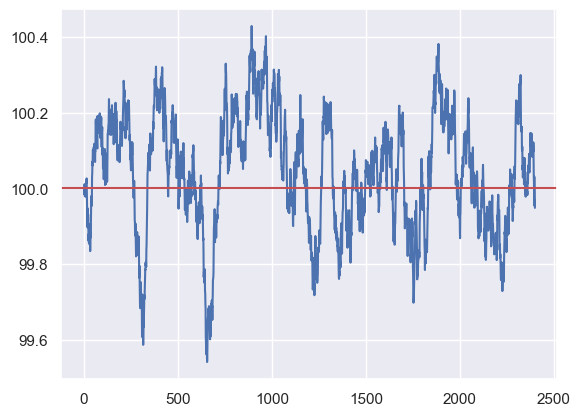

In [56]:
n_plots = 1
for i in range(n_plots):
    plt.plot(synthetic_batch_stock_data[i].numpy())
plt.axhline(y=X_0, color='r', linestyle='-')
plt.show()

In [57]:
depth = 1
delta = 0.1

In [58]:
n_samples = 100
ts = trading_strategy.TradingStrategy(depth, delta)
ts.fit(synthetic_batch_stock_data[:n_samples], info_data[:n_samples])
print(ts.functionals[0])

mu_sig successfully computed
sigma_sig successfully computed
lambda successfully computed
Fitting successful.

tensor([-0.4299,  0.1497,  6.6084])


In [59]:
n_samples = 1000
ts = trading_strategy.TradingStrategy(depth, delta)
ts.fit(synthetic_batch_stock_data[:n_samples], info_data[:n_samples])
print(ts.functionals[0])

function compute_signature took 1.24s
mu_sig successfully computed
sigma_sig successfully computed
lambda successfully computed
Fitting successful.

tensor([-3.1431e-02, -3.4936e-03,  7.2175e+00])


In [60]:
n_samples = 10000
ts = trading_strategy.TradingStrategy(depth, delta)
ts.fit(synthetic_batch_stock_data[:n_samples], info_data[:n_samples])
print('first 1/3 of data')
print(ts.functionals[0])

print('second 1/3 of data')
shift = 10000
ts = trading_strategy.TradingStrategy(depth, delta)
ts.fit(synthetic_batch_stock_data[shift:shift+n_samples], info_data[shift:shift+n_samples])
print(ts.functionals[0])

print('third 1/3 of data')
ts = trading_strategy.TradingStrategy(depth, delta)
ts.fit(synthetic_batch_stock_data[2*shift:2*shift+n_samples], info_data[2*shift:2*shift+n_samples])
print(ts.functionals[0])

function compute_signature took 21.81s
mu_sig successfully computed
sigma_sig successfully computed
lambda successfully computed
Fitting successful.

first 1/3 of data
tensor([-0.1546,  0.1335,  6.8152])
second 1/3 of data
function compute_lead_lag_transform took 1.33s
function compute_signature took 21.00s
mu_sig successfully computed
sigma_sig successfully computed
lambda successfully computed
Fitting successful.

tensor([-0.0832,  0.1070,  6.8953])
third 1/3 of data
function compute_lead_lag_transform took 1.20s
function compute_signature took 22.65s
mu_sig successfully computed
sigma_sig successfully computed
lambda successfully computed
Fitting successful.

tensor([-0.1274,  0.1372,  6.9970])


In [64]:
ts.functionals[0] = -ts.functionals[0]

## In sample

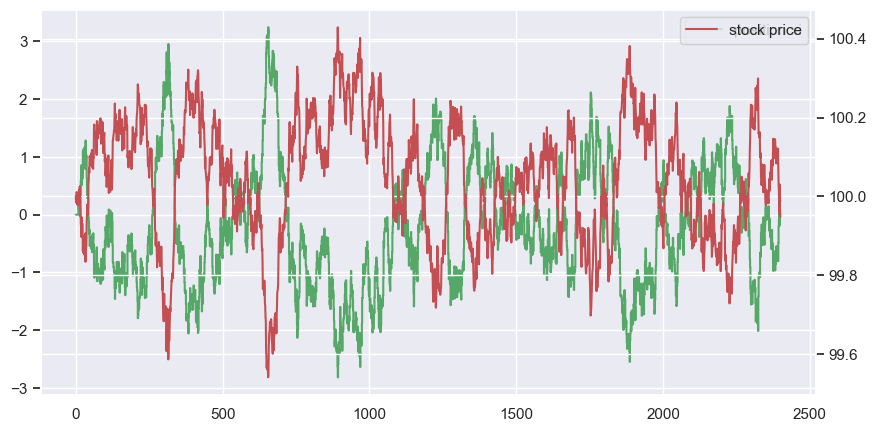

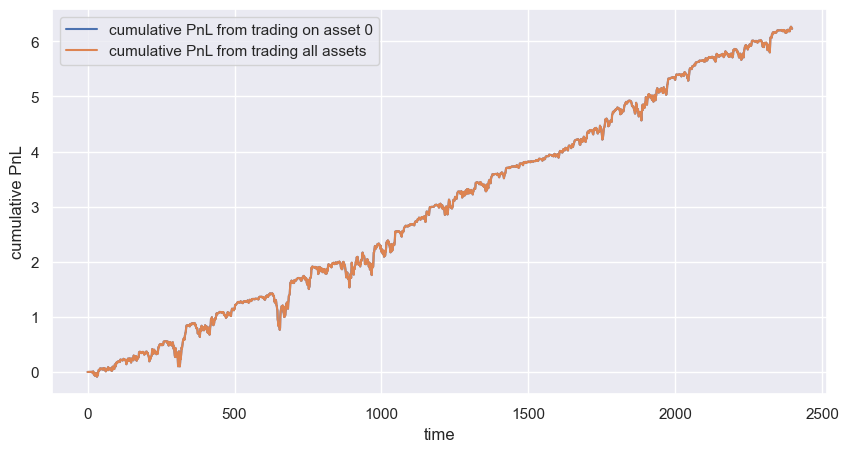

In [66]:
path_index = 0 # path we want to look at
is_stock_data = synthetic_batch_stock_data[path_index]
is_info_data = info_data[path_index]

# let's trade on this path
xi = ts.trade(is_stock_data, is_info_data, min_steps=10)
daily_pnl = ts.compute_pnl(is_stock_data, xi)
cum_pnl = torch.cumsum(daily_pnl, dim=0)

# convert xi to numpy array
xi_np = xi.detach().numpy()
# plot xi
plt.figure(figsize=(10,5))
plt.step(np.arange(len(xi_np)), xi_np, color='g', label='position xi')
plt.legend()
plt.twinx()
plt.plot(is_stock_data, color='r', label='stock price')
plt.legend()
plt.show()

utils.plot_cum_pnl(cum_pnl)

## Out of sample

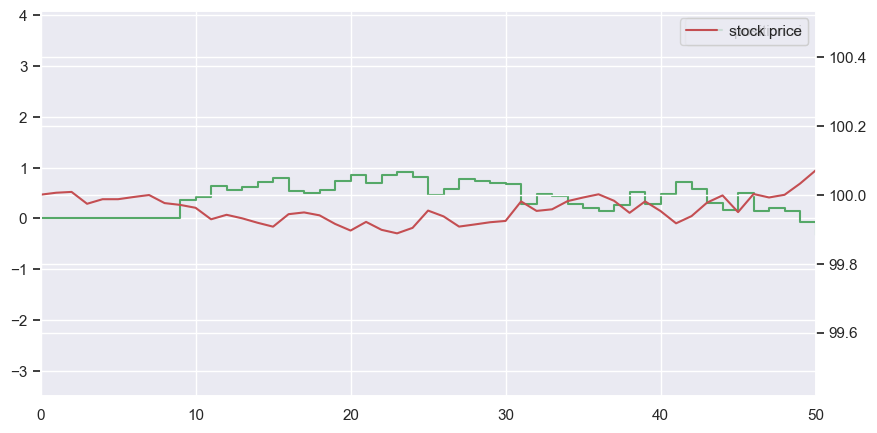

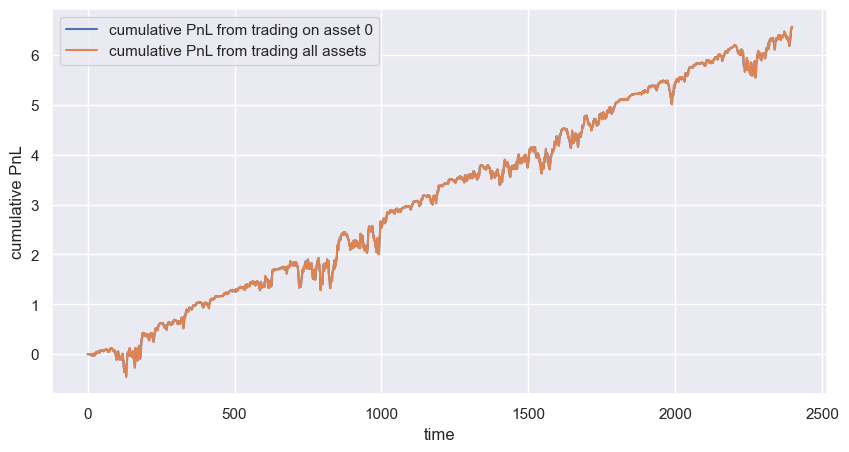

In [67]:
path_index = 0 # path we want to look at
os_stock_data = synthetic_batch_stock_data[path_index+shift]
unseen_info = info_data[path_index+shift]

# let's trade on this path
xi = ts.trade(os_stock_data, unseen_info, min_steps=10)
daily_pnl = ts.compute_pnl(os_stock_data, xi)
cum_pnl = torch.cumsum(daily_pnl, dim=0)

# convert xi to numpy array
xi_np = xi.detach().numpy()
# plot xi
plt.figure(figsize=(10,5))
plt.step(np.arange(len(xi_np)), xi_np, color='g', label='position xi')
plt.legend()
plt.twinx()
plt.plot(os_stock_data, color='r', label='stock price')
plt.legend()

plt.xlim(0, 50)

plt.show()

utils.plot_cum_pnl(cum_pnl)